In [44]:
#preprocessing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import spacy
import re
import torch
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Compiling, general analysis and splitting the data into test, validation and training sets. 

| File/Description                              | Description                                                                                       |
|-----------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Guidelines_Phase1.pdf**                     | The crowdsourcing labeling guidelines for the main annotation task                                |
| **Guidelines_Phase2.pdf**                     | The crowdsourcing labeling guidelines for the verification task                                   |
| **WikiQA.tsv**                                | Original data                                                                                     |
| **WikiQA-train.tsv, WikiQA-dev.tsv, WikiQA-test.tsv** | train/dev/test split of WikiQA.tsv used in this paper                     |
| **WikiQA-train.txt, WikiQA-dev.txt, WikiQA-test.txt** | slightly processed data (tokenization)                                  |
| **WikiQA-train.ref, WikiQA-dev.ref, WikiQA-test.ref** | reference files in TREC evaluation format                               |
| **WikiQA-dev-filtered.ref, WikiQA-test-filtered.ref** | removed all questions without correct answers in the candidate sentence sets (for Answer Sentence Selection evaluation) |
| **WikiQASent.pos.ans.tsv**                    | Questions with answer sentence annotated with answer phrases                                      |
|                                               | **Evaluation Code:**                                                                              |
| **eval.py**                                   | python evaluation code for evaluation of the Answer Triggering task                               |
| **WikiQA.tsv**                               |size: 29208   |
| **WikiQA-dev.tsv**                                |size: 2733|
| **WikiQA-train.tsv**                              |size: 20347 |
| **WikiQA-test.tsv**                               |size: 6116 |
 


As there is no division between testing, validation, and training data, and there might be distribution differences between datasets, the data will be merged, shuffled and then divided into the 3 datasets.

In [45]:
# Given that wikiqa_orig is the original dataset, we will use the following code to load the dataset
wikiqa_orig = pd.read_table('WikiQACorpus/WikiQACorpus/WikiQA.tsv')

In [46]:
# mixing the data to avoid any bias
wikiqa_orig= wikiqa_orig.sample(frac=1).reset_index(drop=True)

In [47]:
# splitting the data into test and training data
df_train_pseudo, df_test = train_test_split(wikiqa_orig, test_size=0.2)
df_train, df_val = train_test_split(df_train_pseudo, test_size=0.2)
df_train.shape, df_val.shape, df_test.shape

((18692, 7), (4674, 7), (5842, 7))

In [48]:
#saving training, validation and test data
df_train.to_csv('WikiQACorpus/train.csv', index=False)
df_val.to_csv('WikiQACorpus/val.csv', index=False)
df_test.to_csv('WikiQACorpus/test.csv', index=False)

In [49]:
# releasing memory
del df_test
del df_val

In [50]:
# checking the columns of the data
df_train.columns

Index(['QuestionID', 'Question', 'DocumentID', 'DocumentTitle', 'SentenceID',
       'Sentence', 'Label'],
      dtype='object')

In [51]:
# checking the first rows of the data
df_train

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
9152,Q2579,what is the tallest building in the western he...,D2410,List of tallest structures in the world by cou...,D2410-1,The list directly includes the tallest buildin...,0
21928,Q928,how much mercury is in a thermometer,D896,Mercury-in-glass thermometer,D896-0,Closeup of a maximum thermometer.,0
19564,Q2704,What is Oprah's network called now?,D2522,Oprah Winfrey,D2522-4,Winfrey was born into poverty in rural Mississ...,0
23530,Q1335,what year was elvis born,D839,Elvis Presley,D839-10,"In November 1956, he made his film debut in Lo...",0
12681,Q2304,what was the role of rio grande valley in the ...,D359,American Civil War,D359-23,"The defending Confederate army failed, leading...",0
...,...,...,...,...,...,...,...
16654,Q1350,what part of the earth is covered with water 1...,D217,Earth,D217-14,The Moon is Earth's only natural satellite .,0
20463,Q1464,what is a store confectioner,D1392,Confectionery store,D1392-1,A confectionery store (more commonly referred ...,1
15532,Q1485,who made the matrix,D1411,The Matrix,D1411-3,The Matrix is known for popularizing a visual ...,0
28101,Q584,how did neil armstrong affect the united states,D575,Apollo 11,D575-8,They stayed a total of about 21 and a half hou...,0


In [52]:
# Checking the shape
df_train.shape

(18692, 7)

In [53]:
# Getting rid of empty text columns
df_train = df_train.dropna(subset=['Sentence'])

In [54]:
df_train['Label'].value_counts()

Label
0    17731
1      961
Name: count, dtype: int64

#### Analysis:
Performed only training dataset. To understand the patterns in the data  without undermining the integrity of validation & testing process.

In [55]:
df_dis_analysis= pd.read_csv('WikiQACorpus/train.csv')

In [56]:
# Sorting the data by QuestionID to make it easier to analyse
df_dis_analysis.sort_values(by='QuestionID', inplace=True)
df_dis_analysis

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
9627,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-4,"They include people from different national, l...",0
13729,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-0,African immigration to the United States refer...,0
5708,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-3,African immigrants in the United States come f...,0
11825,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-5,"As such, African immigrants are to be distingu...",1
18055,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-2,From the Immigration and Nationality Act of 19...,0
...,...,...,...,...,...,...,...
428,Q998,What does Rapture meaning in a theological sense?,D963,Rapture,D963-4,"The other, older use of the term ""Rapture"" is ...",0
5884,Q998,What does Rapture meaning in a theological sense?,D963,Rapture,D963-3,"This is now the most common use of the term, e...",0
15667,Q998,What does Rapture meaning in a theological sense?,D963,Rapture,D963-8,They do not believe that a group of people is ...,0
5507,Q998,What does Rapture meaning in a theological sense?,D963,Rapture,D963-0,The Rapture is a term in Christian eschatology...,1


Question to Sentence analysis.

Distibution of questions

In [57]:
# Checking the number of unique questions
df_dis_analysis['Question'].nunique()

2976

In [58]:
df_dis_analysis['QuestionID'].value_counts()

QuestionID
Q2436    25
Q2184    24
Q953     24
Q648     24
Q1579    24
         ..
Q760      1
Q76       1
Q130      1
Q1886     1
Q999      1
Name: count, Length: 2976, dtype: int64

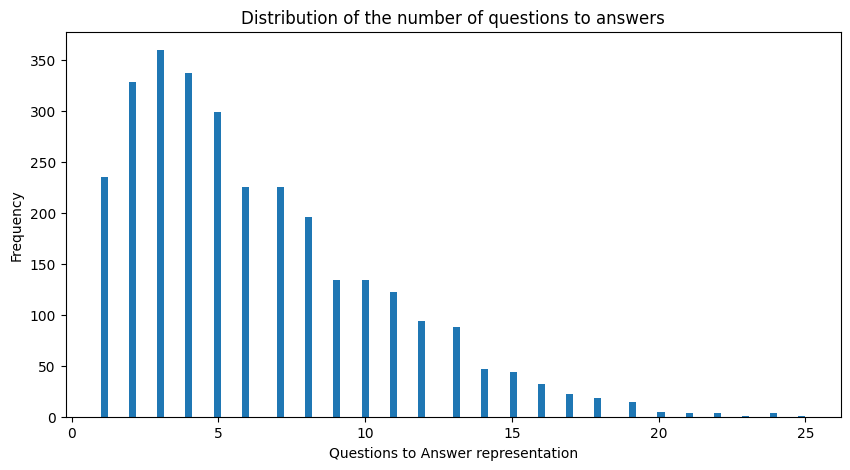

In [59]:
# Graphing the distribution of the number of questions and sentences by QuestionID
plt.figure(figsize=(10, 5))
plt.hist(df_dis_analysis['QuestionID'].value_counts(), bins=100)
plt.title('Distribution of the number of questions to answers')
plt.xlabel('Questions to Answer representation')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

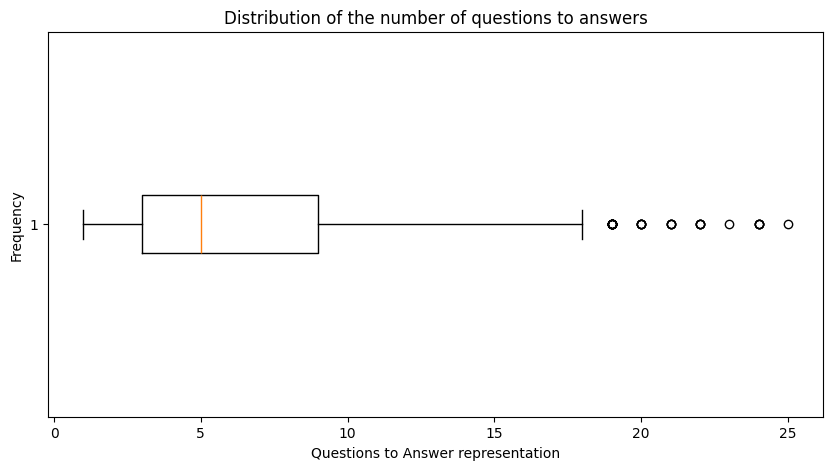

In [60]:
# Box plot of the number of questions and sentences by QuestionID


plt.figure(figsize=(10, 5))
plt.boxplot(df_dis_analysis['QuestionID'].value_counts(), vert=False)
plt.title('Distribution of the number of questions to answers')
plt.xlabel('Questions to Answer representation')
plt.ylabel('Frequency')

In [61]:
df_dis_analysis['QuestionID'].value_counts().median()

5.0

In [62]:
# Upper quartile, lower quartile and median
def quartile_analysis_responder(df):
    dic={}
    dic['q3'] = df['QuestionID'].value_counts().quantile(0.75)
    dic['q1'] = df['QuestionID'].value_counts().quantile(0.25)
    dic['median'] = df['QuestionID'].value_counts().median()
    
    # Interquartile range
    dic['iqr'] = dic['q3'] - dic['q1']
    
    # Lower acceptable limit
    dic['lower_limit'] = dic['q1'] - 1.5*dic['iqr']
    
    # Upper acceptable limit
    dic['upper_limit'] = dic['q3'] + 1.5*dic['iqr']
    
    # Numebr of questions that are below the lower limit
    dic['n_below_lower_limit'] = df['QuestionID'].value_counts()[df['QuestionID'].value_counts()<dic['lower_limit']].shape[0]
    
    # Number of questions that are above the upper limit
    dic['n_above_upper_limit'] = df['QuestionID'].value_counts()[df['QuestionID'].value_counts()>dic['upper_limit']].shape[0]
    
    return dic
    
quartile_val=quartile_analysis_responder(df_dis_analysis)
quartile_val

{'q3': 9.0,
 'q1': 3.0,
 'median': 5.0,
 'iqr': 6.0,
 'lower_limit': -6.0,
 'upper_limit': 18.0,
 'n_below_lower_limit': 0,
 'n_above_upper_limit': 33}

In [63]:
# Saving the data to manually remove the outliers to bring with in the upper limit
df_dis_analysis.to_csv('WikiQACorpus/train_remove_outliers.csv', index=False)
df_dis_analysis['QuestionID'].value_counts().to_csv('WikiQACorpus/question_id_freq.csv')

In [64]:
# Manually prepped data
df_dis_analysis = pd.read_csv('WikiQACorpus/train_remove_outliers_prepped.csv')

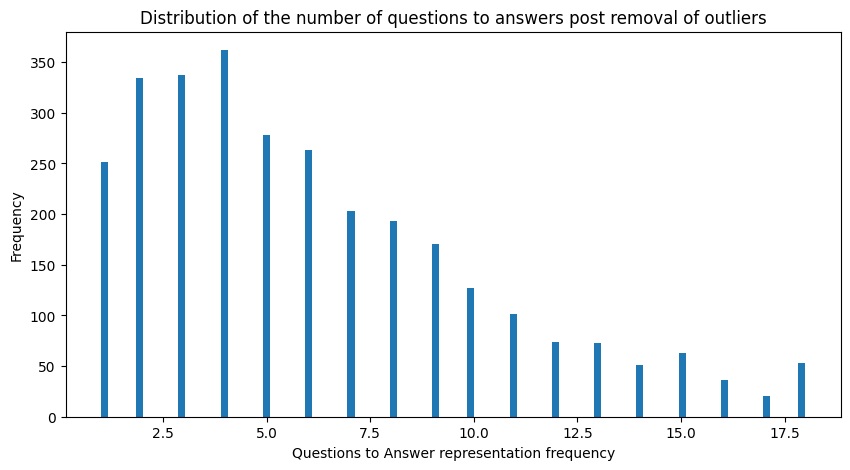

In [65]:
# Graphing the distribution of the number of questions post removal of outliers

plt.figure(figsize=(10, 5))
plt.hist(df_dis_analysis['Question'].value_counts(), bins=100)
plt.title('Distribution of the number of questions to answers post removal of outliers')
plt.xlabel('Questions to Answer representation frequency')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

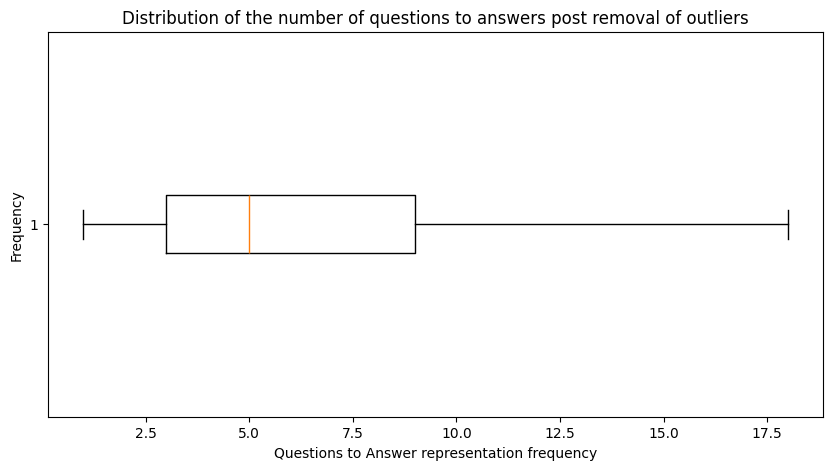

In [66]:
# Box plot of the number of questions post removal of outliers

plt.figure(figsize=(10, 5))
plt.boxplot(df_dis_analysis['Question'].value_counts(), vert=False)
plt.title('Distribution of the number of questions to answers post removal of outliers')
plt.xlabel('Questions to Answer representation frequency')
plt.ylabel('Frequency')

Word Cloud representation of the DoucmentTitle feature to understand the prevalence of certain topics. 

NLP Analysis

In [67]:
df_spacy_analysis = pd.read_csv('WikiQACorpus/train.csv')

In [68]:
# Enable GPU for spacy
spacy.require_gpu()

True

In [69]:
# loading the spacy model
analysis_nlp = spacy.load('en_core_web_lg')

 Sentence and word count graphing

In [70]:
# Aggregate questions and their sentences, and keep QuestionID for reference
def agg_question_sentence(df_spacy_analysis):
    # Group by QuestionID and Question, then join the sentences
    df_agg = df_spacy_analysis.groupby(['QuestionID', 'Question']).agg({'Sentence': ' '.join}).reset_index()
    return df_agg

# Calculate sentence count using spaCy
def spacy_sentence_count(text, analysis_nlp):
    doc = analysis_nlp(text)
    return len(list(doc.sents))

# Calculate word count using spaCy
def spacy_word_count(text, analysis_nlp):
    doc = analysis_nlp(text)
    return len(doc)


# Aggregate sentences by question
df_counts = agg_question_sentence(df_spacy_analysis)

# Add sentence and word counts to the dataframe
df_counts['question_sentence_count'] = df_counts['Question'].apply(lambda text: spacy_sentence_count(text, analysis_nlp))
df_counts['answer_sentence_count'] = df_counts['Sentence'].apply(lambda text: spacy_sentence_count(text, analysis_nlp))
df_counts['question_word_count'] = df_counts['Question'].apply(lambda text: spacy_word_count(text, analysis_nlp))
df_counts['answer_word_count'] = df_counts['Sentence'].apply(lambda text: spacy_word_count(text, analysis_nlp))

# No need to drop columns since they're required for analysis
# Reordering columns for clarity
col_order = ['QuestionID', 'question_sentence_count', 'answer_sentence_count', 'question_word_count', 'answer_word_count']
df_counts = df_counts[col_order]


In [71]:
# Saving the dataframe
df_counts.to_csv('WikiQACorpus/train_word_sentence_counts.csv', index=False)

In [72]:
# Loading the dataframe
df_counts = pd.read_csv('WikiQACorpus/train_word_sentence_counts.csv')

In [73]:
# Total number of sentences and words in the dataset
df_counts['question_word_count'].sum(), df_counts['answer_word_count'].sum(),df_counts['question_sentence_count'].sum(), df_counts['answer_sentence_count'].sum()

print(f'Total number of words in the questions: {df_counts["question_word_count"].sum()}'
      f'\nTotal number of words in the answers: {df_counts["answer_word_count"].sum()}'
      f'\nTotal number of sentences in the questions: {df_counts["question_sentence_count"].sum()}'
      f'\nTotal number of sentences in the answers: {df_counts["answer_sentence_count"].sum()}')


Total number of words in the questions: 21500
Total number of words in the answers: 482294
Total number of sentences in the questions: 2993
Total number of sentences in the answers: 18251


In [74]:
# Word range for questions and answers
print("question word count: ", df_counts['question_word_count'].min(),"to", df_counts['question_word_count'].max(), 
      "Sentence word count: ", df_counts['answer_word_count'].min(),"to" ,df_counts['answer_word_count'].max())
print(df_counts['question_word_count'].max() - df_counts['question_word_count'].min(), 
      df_counts['answer_word_count'].max() - df_counts['answer_word_count'].min())

question word count:  2 to 27 Sentence word count:  3 to 1457
25 1454


In [75]:
# Sentence range for questions and answers
print("question sentence count: ", df_counts['question_sentence_count'].min(),"to", df_counts['question_sentence_count'].max(), 
      "Sentence sentence count: ", df_counts['answer_sentence_count'].min(),"to" ,df_counts['answer_sentence_count'].max())
print(df_counts['question_sentence_count'].max() - df_counts['question_sentence_count'].min(), 
      df_counts['answer_sentence_count'].max() - df_counts['answer_sentence_count'].min())

question sentence count:  1 to 6 Sentence sentence count:  1 to 25
5 24


Q1: 5.0, median: 7.0, Q3: 8.0, iqr: 3.0, lower_limit: 0.5, upper_limit: 12.5, n_below_lower_limit: 0, n_above_upper_limit: 116


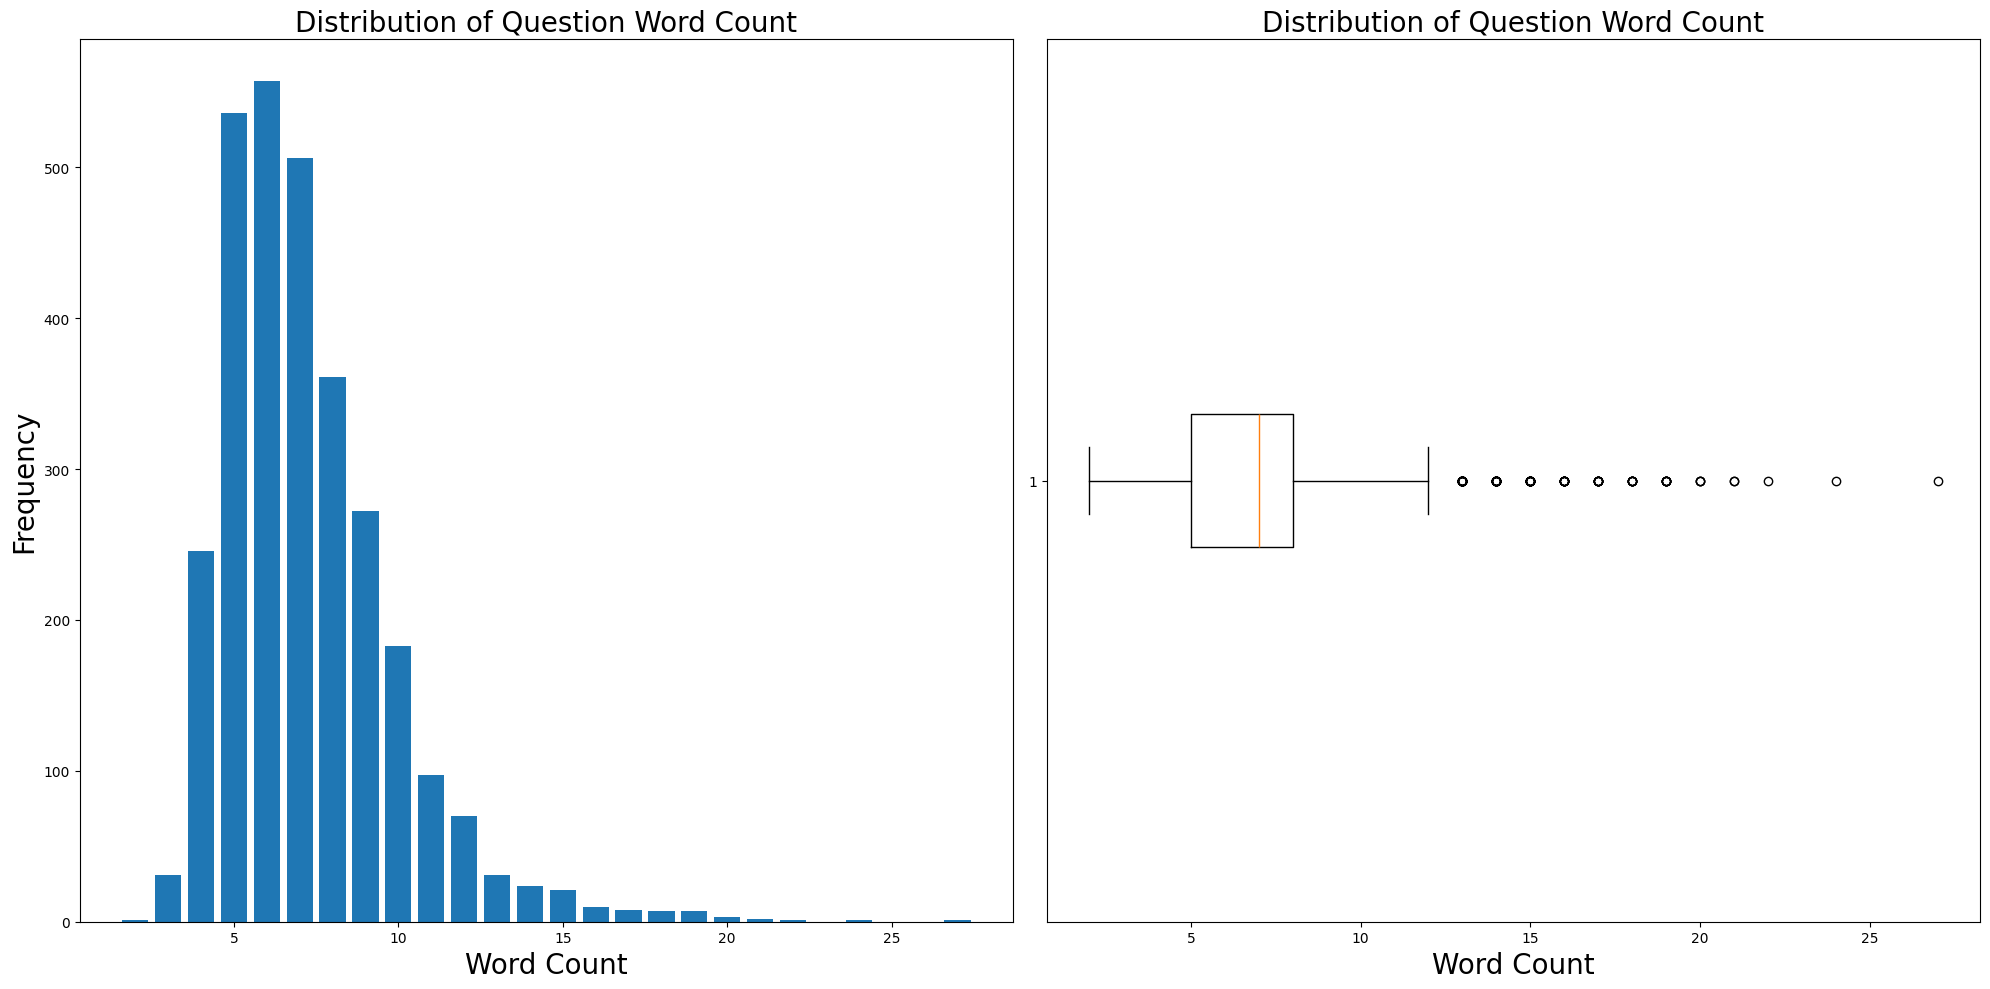

In [76]:
# Graphing the distribution of the number of words for questions

plt.figure(figsize=(20, 10))

# First subplot for the bar chart
plt.subplot(1, 2, 1) # (rows, columns, panel number)
word_counts_series = df_counts['question_word_count'].value_counts()
plt.bar(word_counts_series.index, word_counts_series.values)
plt.title('Distribution of Question Word Count', fontsize=20)
plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Second subplot for the box plot
plt.subplot(1, 2, 2) 
plt.boxplot(df_counts['question_word_count'], vert=False) 
plt.title('Distribution of Question Word Count', fontsize=20)
plt.xlabel('Word Count', fontsize=20)

# Statistics
q3 = df_counts['question_word_count'].quantile(0.75)
q1 = df_counts['question_word_count'].quantile(0.25)
median = df_counts['question_word_count'].median()
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr
n_below_lower_limit = df_counts['question_word_count'][df_counts['question_word_count']<lower_limit].shape[0]
n_above_upper_limit = df_counts['question_word_count'][df_counts['question_word_count']>upper_limit].shape[0]
print(f'Q1: {q1}, median: {median}, Q3: {q3}, iqr: {iqr}, lower_limit: {lower_limit}, upper_limit: {upper_limit}, n_below_lower_limit: {n_below_lower_limit}, n_above_upper_limit: {n_above_upper_limit}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


Q1: 72.0, median: 136.0, Q3: 229.0, iqr: 157.0, lower_limit: -163.5, upper_limit: 464.5, n_below_lower_limit: 0, n_above_upper_limit: 51


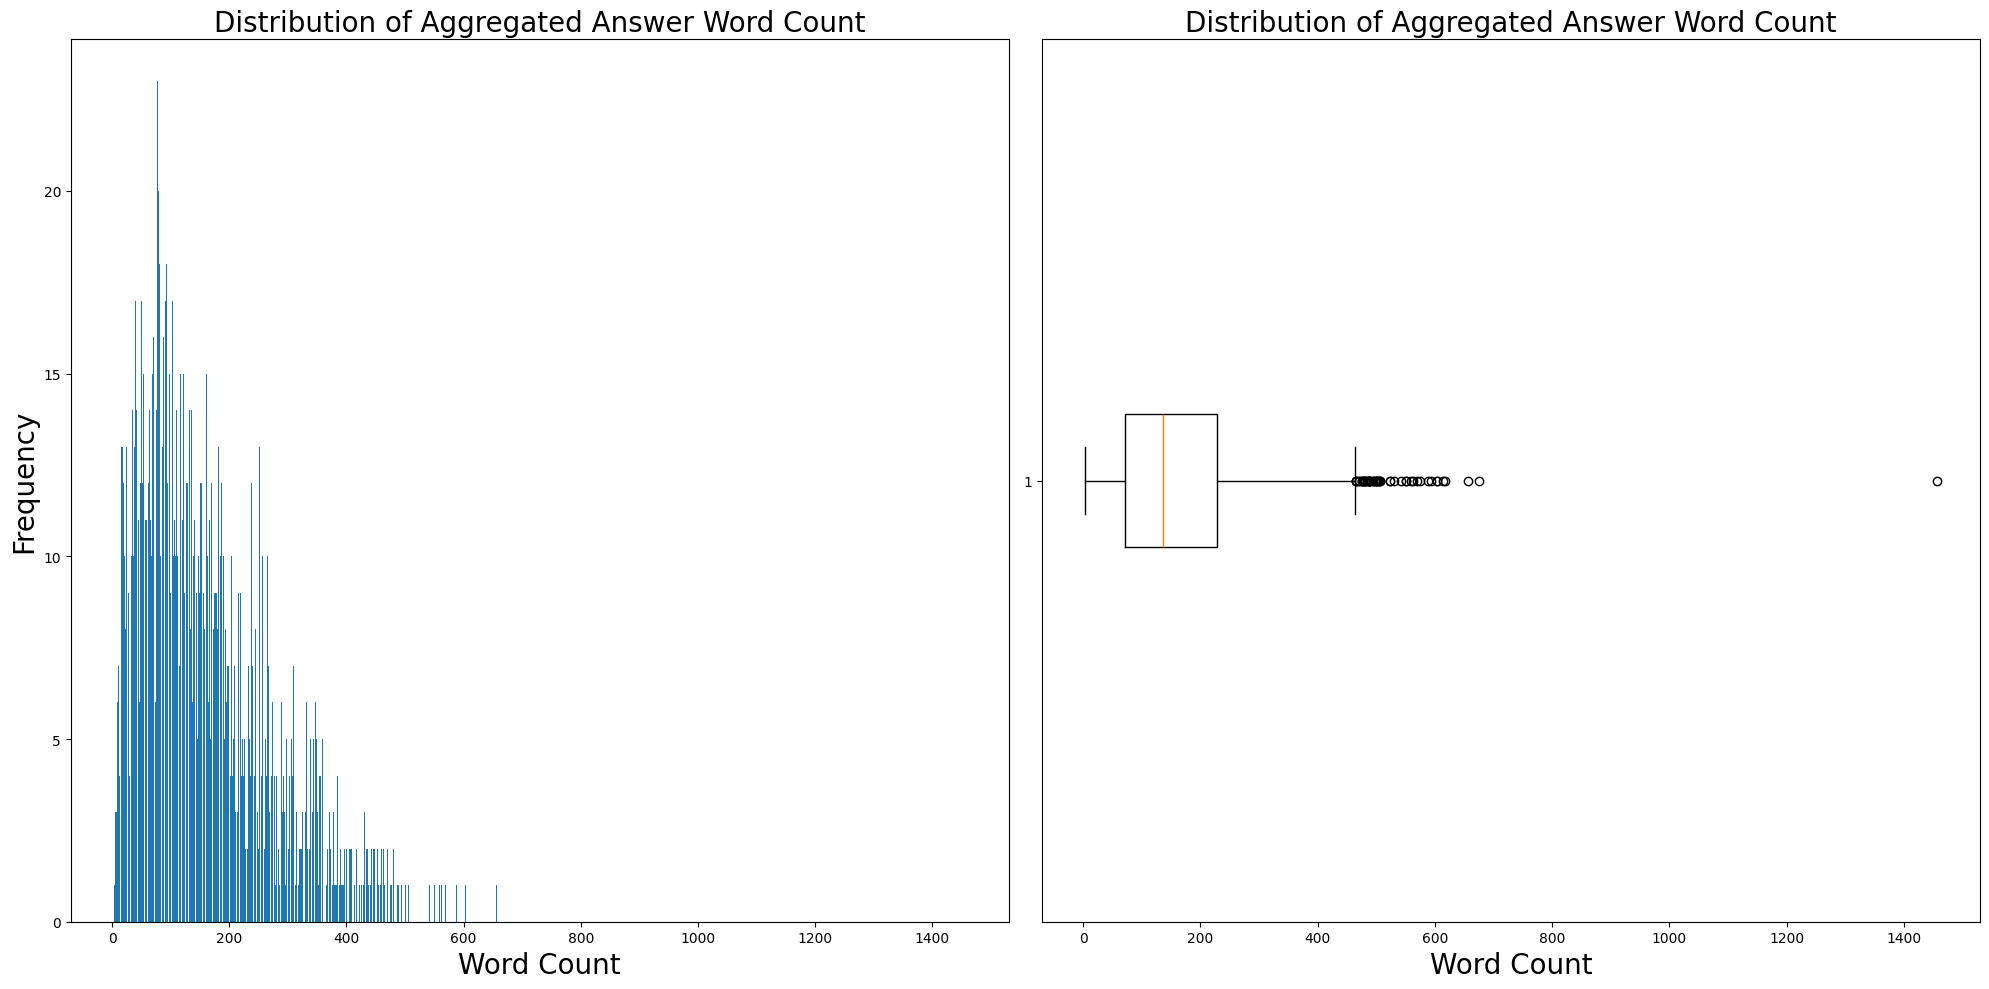

In [77]:
# Graphing the distribution of the number of aggregated answers of words for questions

plt.figure(figsize=(20, 10))

# First subplot for the bar chart
plt.subplot(1, 2, 1) # (rows, columns, panel number)
word_counts_series = df_counts['answer_word_count'].value_counts()
plt.bar(word_counts_series.index, word_counts_series.values)
plt.title('Distribution of Aggregated Answer Word Count', fontsize=20)
plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Second subplot for the box plot
plt.subplot(1, 2, 2) 
plt.boxplot(df_counts['answer_word_count'], vert=False) 
plt.title('Distribution of Aggregated Answer Word Count', fontsize=20)
plt.xlabel('Word Count', fontsize = 20)
# Statistics
q3 = df_counts['answer_word_count'].quantile(0.75)
q1 = df_counts['answer_word_count'].quantile(0.25)
median = df_counts['answer_word_count'].median()
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr
n_below_lower_limit = df_counts['answer_word_count'][df_counts['answer_word_count']<lower_limit].shape[0]
n_above_upper_limit = df_counts['answer_word_count'][df_counts['answer_word_count']>upper_limit].shape[0]
print(f'Q1: {q1}, median: {median}, Q3: {q3}, iqr: {iqr}, lower_limit: {lower_limit}, upper_limit: {upper_limit}, n_below_lower_limit: {n_below_lower_limit}, n_above_upper_limit: {n_above_upper_limit}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

Q1: 1.0, median: 1.0, Q3: 1.0, iqr: 0.0, lower_limit: 1.0, upper_limit: 1.0, n_below_lower_limit: 0, n_above_upper_limit: 13


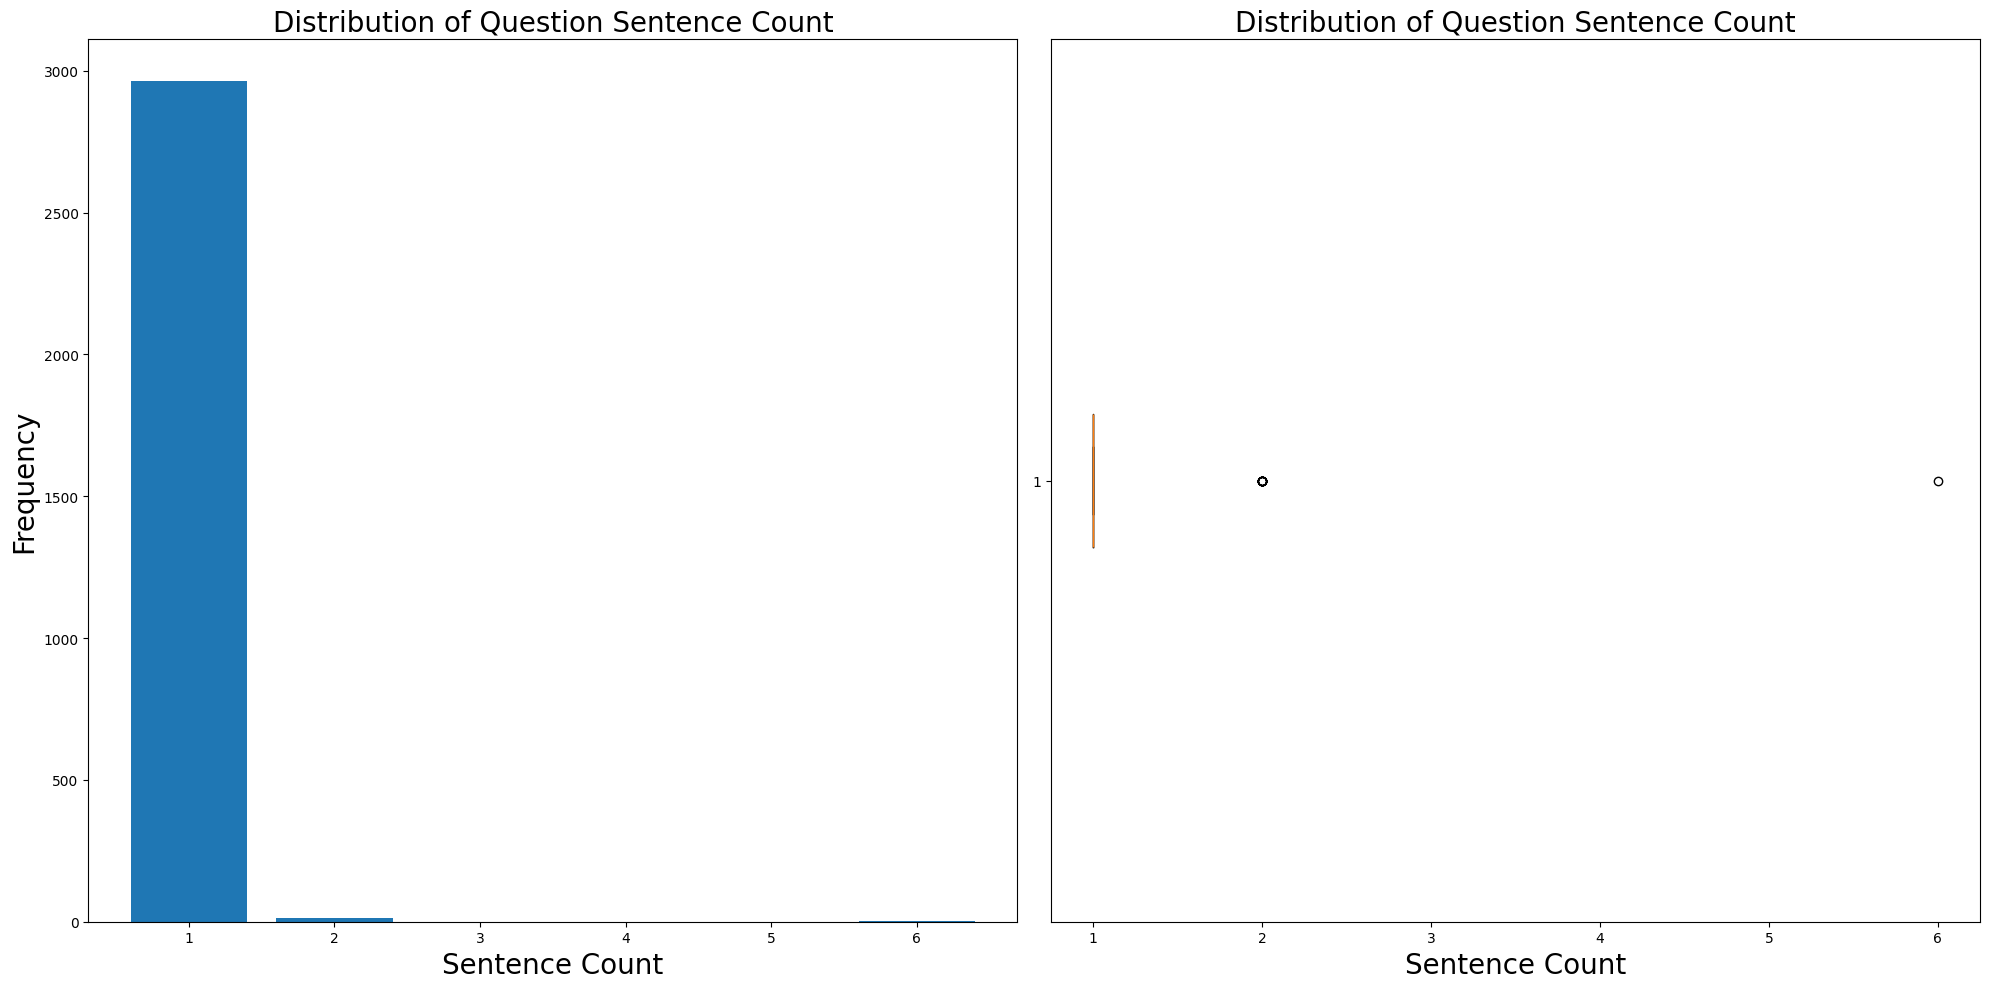

In [78]:
# Graphing the distribution of the number of sentences for questions

plt.figure(figsize=(20, 10))

# First subplot for the bar chart
plt.subplot(1, 2, 1) # (rows, columns, panel number)
word_counts_series = df_counts['question_sentence_count'].value_counts()
plt.bar([1,2,6], word_counts_series.values)
plt.title('Distribution of Question Sentence Count', fontsize=20)
plt.xlabel('Sentence Count', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)

# Second subplot for the box plot
plt.subplot(1, 2, 2) 
plt.boxplot(df_counts['question_sentence_count'], vert=False) 
plt.title('Distribution of Question Sentence Count', fontsize=20)
plt.xlabel('Sentence Count', fontsize = 20)
# Statistics
q3 = df_counts['question_sentence_count'].quantile(0.75)
q1 = df_counts['question_sentence_count'].quantile(0.25)
median = df_counts['question_sentence_count'].median()
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr
n_below_lower_limit = df_counts['question_sentence_count'][df_counts['question_sentence_count']<lower_limit].shape[0]
n_above_upper_limit = df_counts['question_sentence_count'][df_counts['question_sentence_count']>upper_limit].shape[0]
print(f'Q1: {q1}, median: {median}, Q3: {q3}, iqr: {iqr}, lower_limit: {lower_limit}, upper_limit: {upper_limit}, n_below_lower_limit: {n_below_lower_limit}, n_above_upper_limit: {n_above_upper_limit}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


Q1: 3.0, median: 5.0, Q3: 8.0, iqr: 5.0, lower_limit: -4.5, upper_limit: 15.5, n_below_lower_limit: 0, n_above_upper_limit: 92


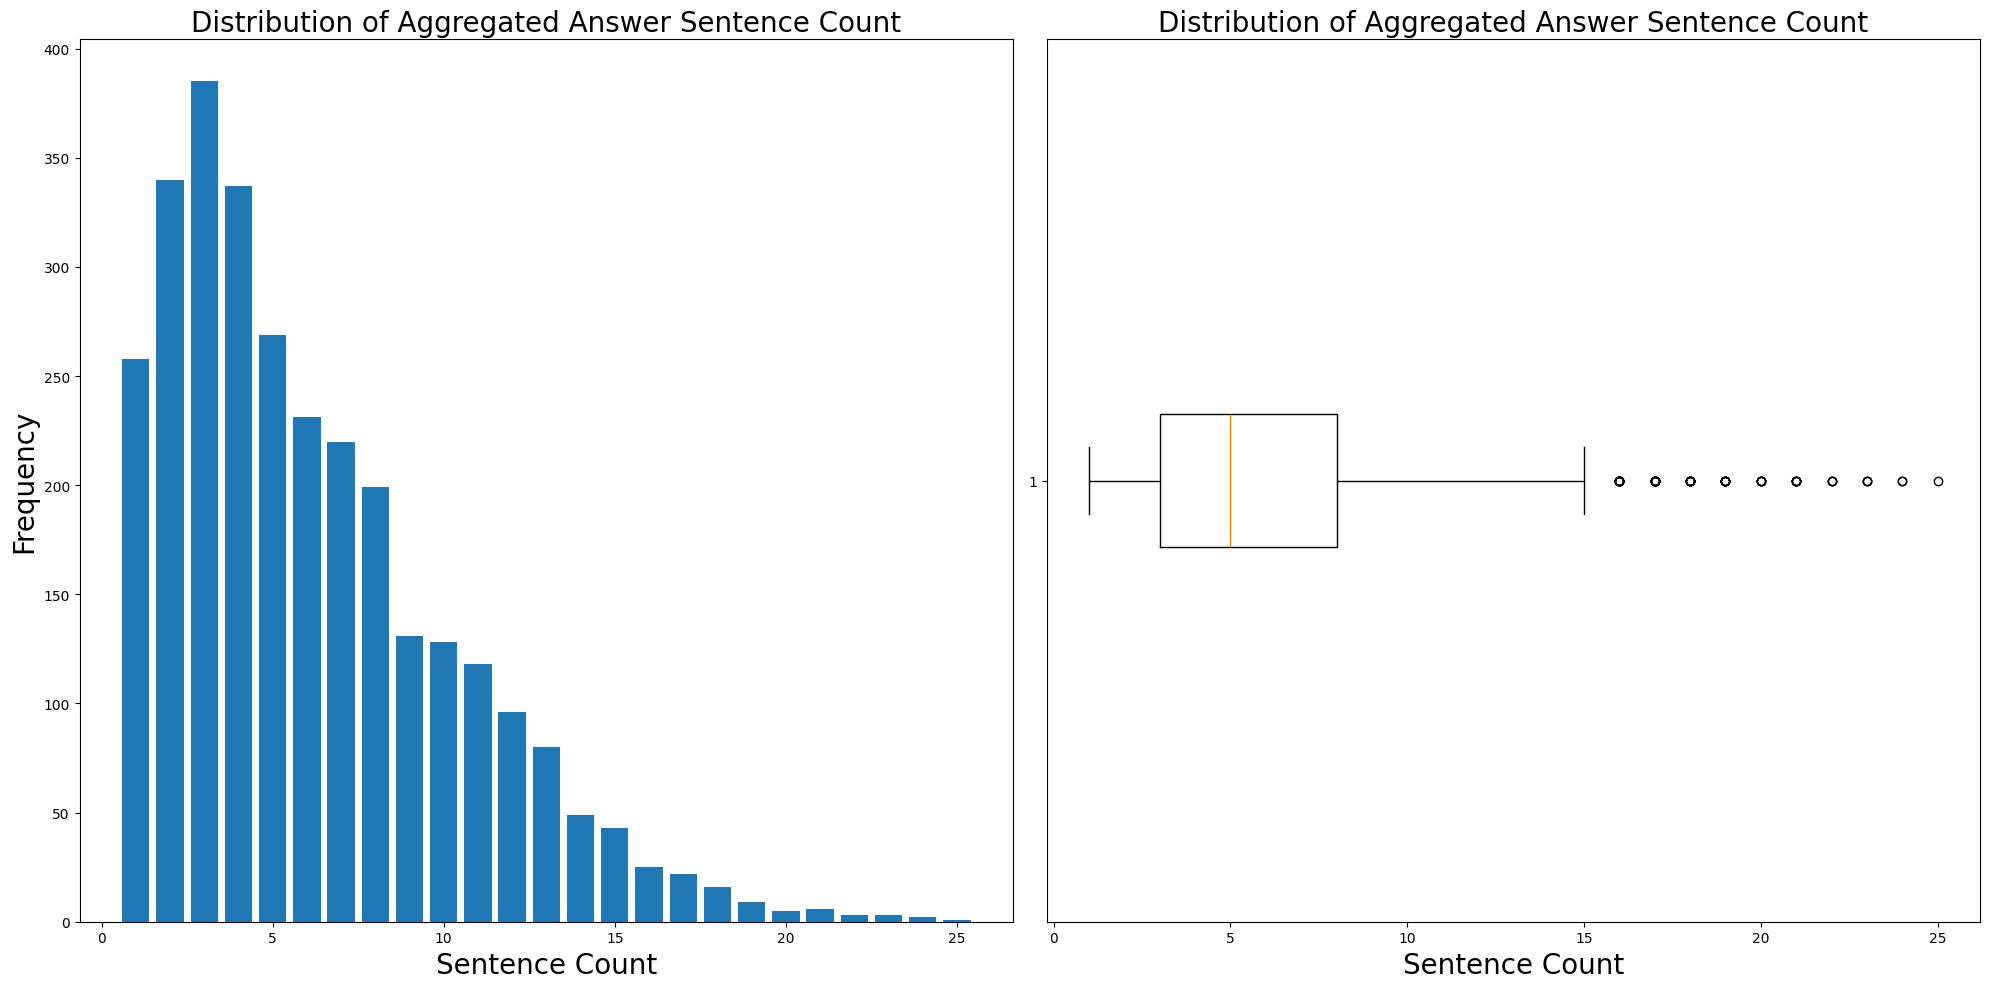

In [79]:
# Graphing the distribution of the number of aggregated answers of sentences for questions

plt.figure(figsize=(20, 10))

# First subplot for the bar chart
plt.subplot(1, 2, 1) # (rows, columns, panel number)
word_counts_series = df_counts['answer_sentence_count'].value_counts()
plt.bar(word_counts_series.index, word_counts_series.values)
plt.title('Distribution of Aggregated Answer Sentence Count', fontsize=20)
plt.xlabel('Sentence Count', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)

# Second subplot for the box plot
plt.subplot(1, 2, 2) 
plt.boxplot(df_counts['answer_sentence_count'], vert=False) 
plt.title('Distribution of Aggregated Answer Sentence Count', fontsize=20)
plt.xlabel('Sentence Count', fontsize = 20)
# Statistics
q3 = df_counts['answer_sentence_count'].quantile(0.75)
q1 = df_counts['answer_sentence_count'].quantile(0.25)
median = df_counts['answer_sentence_count'].median()
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr
n_below_lower_limit = df_counts['answer_sentence_count'][df_counts['answer_sentence_count']<lower_limit].shape[0]
n_above_upper_limit = df_counts['answer_sentence_count'][df_counts['answer_sentence_count']>upper_limit].shape[0]
print(f'Q1: {q1}, median: {median}, Q3: {q3}, iqr: {iqr}, lower_limit: {lower_limit}, upper_limit: {upper_limit}, n_below_lower_limit: {n_below_lower_limit}, n_above_upper_limit: {n_above_upper_limit}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [80]:
# Number of sentences and words concerning answers without aggregation

def spacy_sentence_count(text, analysis_nlp):
    doc = analysis_nlp(text)
    return len(list(doc.sents))

# Calculate word count using spaCy
def spacy_word_count(text, analysis_nlp):
    doc = analysis_nlp(text)
    return len(doc)


# Add sentence and word counts to the dataframe
df_spacy_analysis['sentence_count'] = df_spacy_analysis['Sentence'].apply(lambda text: spacy_sentence_count(text, analysis_nlp))
df_spacy_analysis['word_count'] = df_spacy_analysis['Sentence'].apply(lambda text: spacy_word_count(text, analysis_nlp))

# No need to drop columns since they're required for analysis
# Reordering columns for clarity
col_order = ['QuestionID','Question', 'Sentence', 'sentence_count', 'word_count']
df_answer_counts = df_spacy_analysis[col_order]


In [81]:
df_answer_counts.to_csv('WikiQACorpus/train_answer_no_aggregation.csv', index=False)

In [82]:
df_answer_counts = pd.read_csv('WikiQACorpus/train_answer_no_aggregation.csv')

Q1: 16.0, median: 23.0, Q3: 33.0, iqr: 17.0, lower_limit: -9.5, upper_limit: 58.5, n_below_lower_limit: 0, n_above_upper_limit: 430


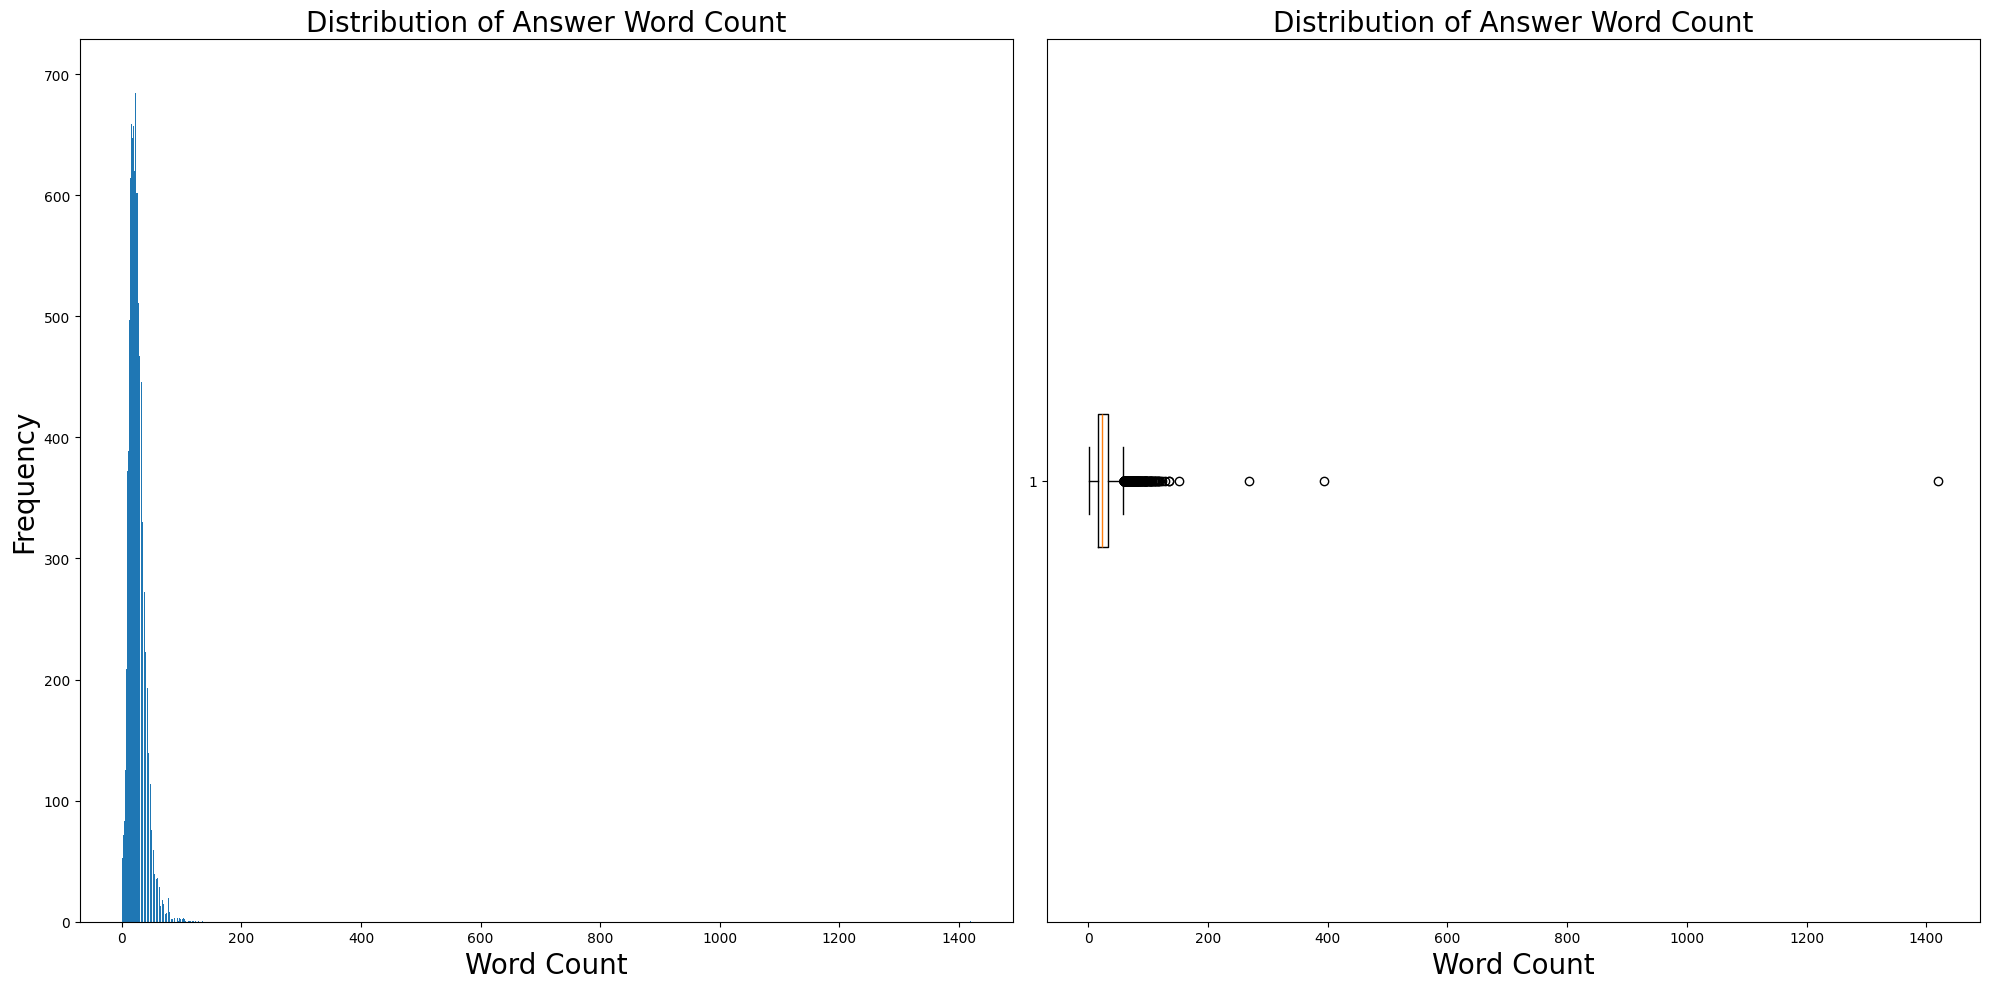

In [83]:
# Graphing the distribution of the number of aggregated answers of words for questions

plt.figure(figsize=(20, 10))

# First subplot for the bar chart
plt.subplot(1, 2, 1) # (rows, columns, panel number)
word_counts_series = df_answer_counts['word_count'].value_counts()
plt.bar(word_counts_series.index, word_counts_series.values)
plt.title('Distribution of Answer Word Count', fontsize=20)
plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

# Second subplot for the box plot
plt.subplot(1, 2, 2) 
plt.boxplot(df_answer_counts['word_count'], vert=False) 
plt.title('Distribution of Answer Word Count', fontsize=20)
plt.xlabel('Word Count', fontsize = 20)
# Statistics
q3 = df_answer_counts['word_count'].quantile(0.75)
q1 = df_answer_counts['word_count'].quantile(0.25)
median = df_answer_counts['word_count'].median()
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr
n_below_lower_limit = df_answer_counts['word_count'][df_answer_counts['word_count']<lower_limit].shape[0]
n_above_upper_limit = df_answer_counts['word_count'][df_answer_counts['word_count']>upper_limit].shape[0]
print(f'Q1: {q1}, median: {median}, Q3: {q3}, iqr: {iqr}, lower_limit: {lower_limit}, upper_limit: {upper_limit}, n_below_lower_limit: {n_below_lower_limit}, n_above_upper_limit: {n_above_upper_limit}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

Q1: 1.0, median: 1.0, Q3: 1.0, iqr: 0.0, lower_limit: 1.0, upper_limit: 1.0, n_below_lower_limit: 0, n_above_upper_limit: 147


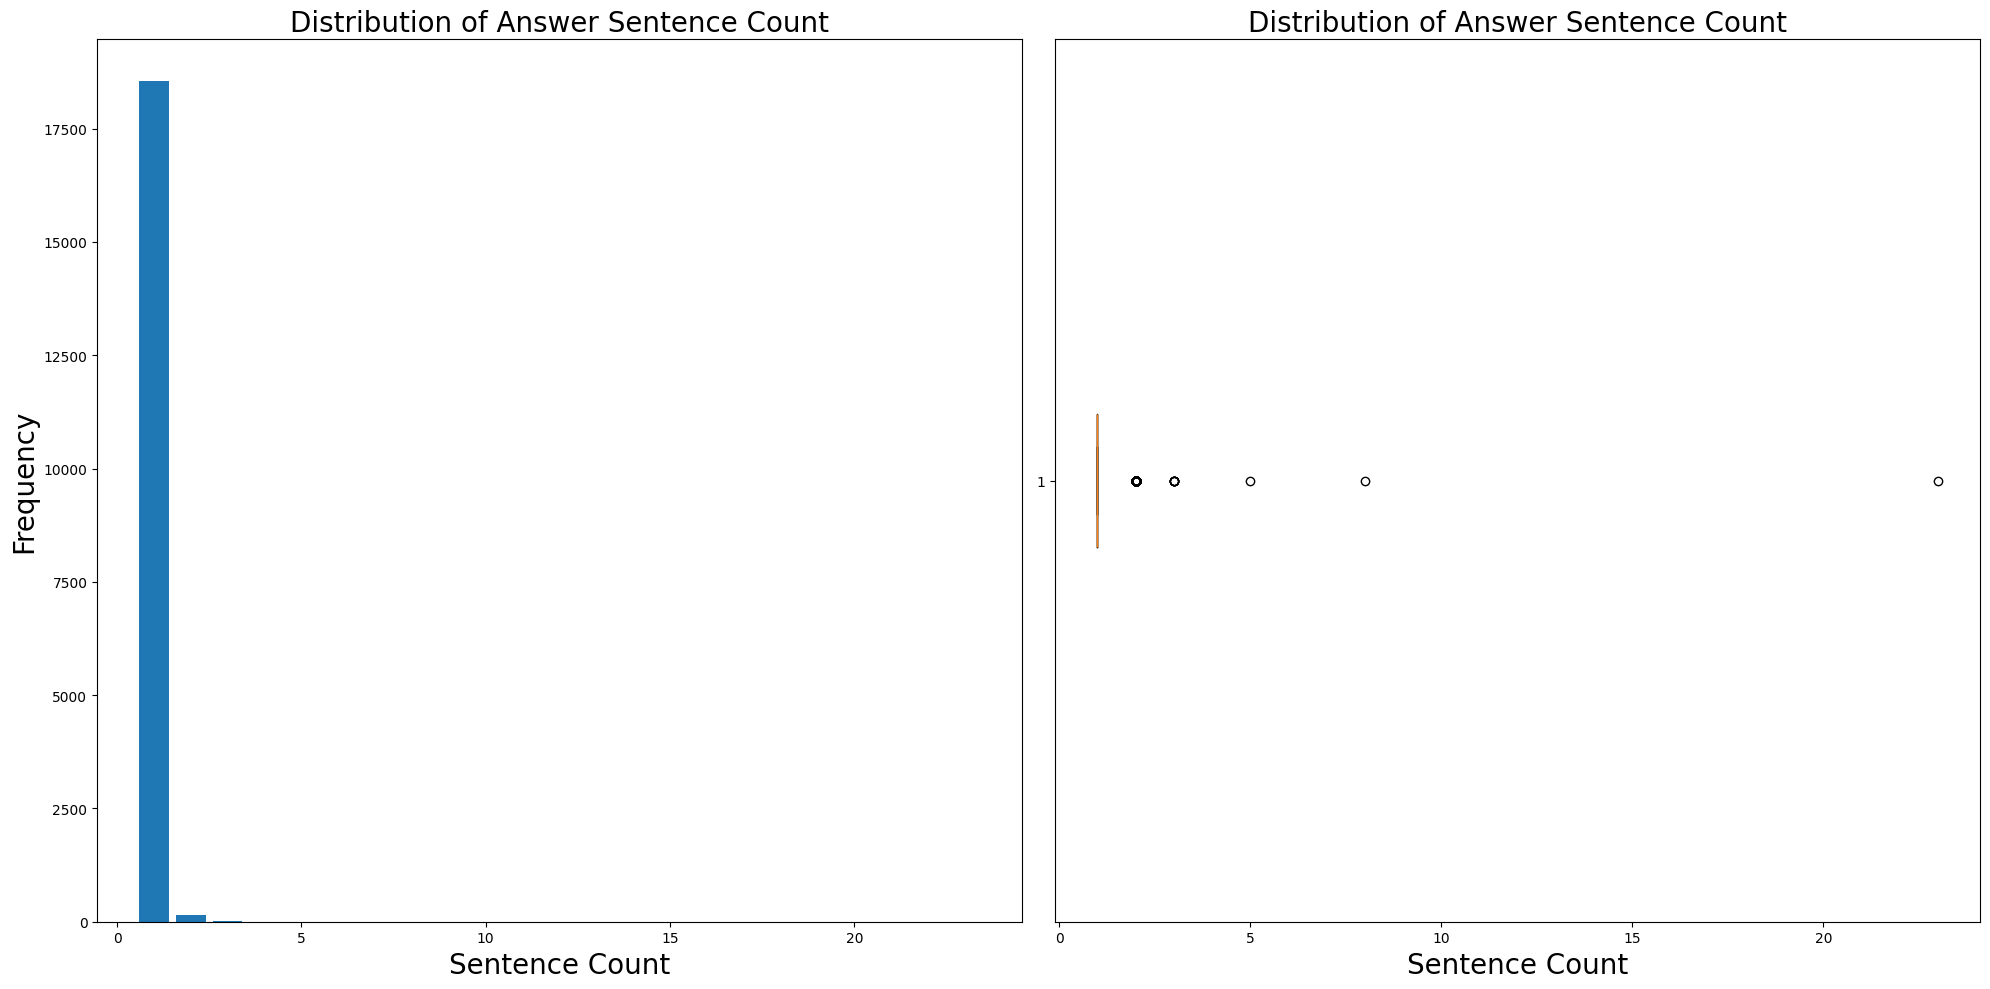

In [84]:
# Graphing the distribution of the number of sentences for answers with no aggregations

plt.figure(figsize=(20, 10))

# First subplot for the bar chart
plt.subplot(1, 2, 1) # (rows, columns, panel number)
word_counts_series = df_answer_counts['sentence_count'].value_counts()
plt.bar(word_counts_series.index, word_counts_series.values)
plt.title('Distribution of Answer Sentence Count', fontsize=20)
plt.xlabel('Sentence Count', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)

# Second subplot for the box plot
plt.subplot(1, 2, 2) 
plt.boxplot(df_answer_counts['sentence_count'], vert=False) 
plt.title('Distribution of Answer Sentence Count', fontsize=20)
plt.xlabel('Sentence Count', fontsize = 20)
# Statistics
q3 = df_answer_counts['sentence_count'].quantile(0.75)
q1 = df_answer_counts['sentence_count'].quantile(0.25)
median = df_answer_counts['sentence_count'].median()
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr
n_below_lower_limit = df_answer_counts['sentence_count'][df_answer_counts['sentence_count']<lower_limit].shape[0]
n_above_upper_limit = df_answer_counts['sentence_count'][df_answer_counts['sentence_count']>upper_limit].shape[0]
print(f'Q1: {q1}, median: {median}, Q3: {q3}, iqr: {iqr}, lower_limit: {lower_limit}, upper_limit: {upper_limit}, n_below_lower_limit: {n_below_lower_limit}, n_above_upper_limit: {n_above_upper_limit}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

Spacy pipline to standardise text for word and phase analysis

In [85]:
df_spacy_analysis = pd.read_csv('WikiQACorpus/train.csv')

In [86]:
# Saving shape to assess the number of rows removed
df_original_shape = df_spacy_analysis.shape[0]

In [87]:
# Enable GPU for spacy
spacy.require_gpu()

True

In [88]:
# Load the spacy model
analysis_nlp = spacy.load('en_core_web_lg')

In [89]:
# Spacy to tokeniser, lemmatiser, stop word removal, punctuation removal, number removal
def strict_spacy_analysis(text):
    doc = analysis_nlp(text.lower())
    # Tokeniser, lemmatizer, stop word removal, punctuation removal, number removal, lower case
    return "".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not token.is_punct])

In [90]:
# Standardise the text using spacy
# Numbers kept as they are useful for the task given that some questions or answers may contain numbers that are relevant to the task
def cautious_spacy_analysis(text):
    doc = analysis_nlp(text.lower())
    # tokeniser, lemmatizer, stop word removal, punctuation removal, number keeping, lower case
    return " ".join([token.lemma_ for token in doc if (token.is_alpha or token.like_num) and not token.is_stop and not token.is_punct]).lower()

# Apply the spacy pipeline to setence and question
df_spacy_analysis.loc[:,'Sentence'] = df_spacy_analysis['Sentence'].apply(cautious_spacy_analysis)
df_spacy_analysis.loc[:,'Question'] = df_spacy_analysis['Question'].apply(cautious_spacy_analysis)

In [91]:
# Dropping empty text cells
def drop_empty_text(df):
    df.drop(df[df['Sentence']==''].index, inplace=True)
    df.drop(df[df['Question']==''].index, inplace=True)

drop_empty_text(df_spacy_analysis)

# Difference in shape
(df_spacy_analysis.shape[0]/df_original_shape)*100

99.75390541408089

In [92]:
# Assess how to group the data either by QuestionID or DocumentTitle. Given that many questions can belong to a single DocumentTitle. 
# That means these questions may have relational patterns that can be exploited to improve the model's performance. 
df_spacy_analysis['DocumentTitle'].nunique(), df_spacy_analysis['Question'].nunique()

(2739, 2960)

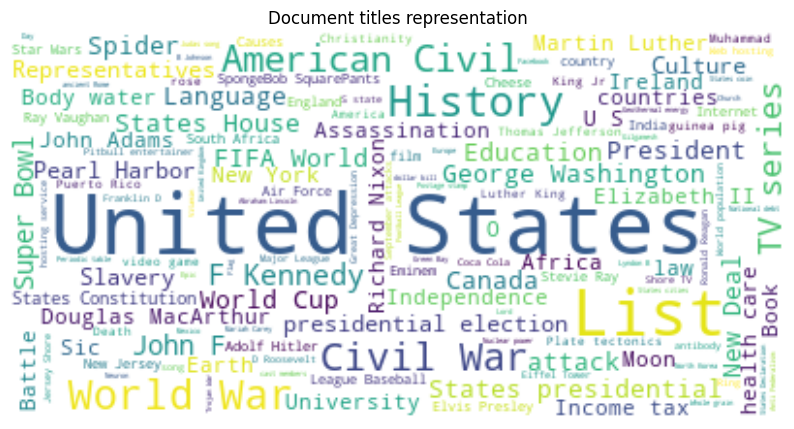

In [93]:
# Word cloud of the document titles
text = ''
for title in df_spacy_analysis['DocumentTitle']:
    text += title + ' '

# Create a word cloud
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Document titles representation')
plt.show()

In [94]:
# Post spacy pipeline. To save time and memory, we will save the data and load it again
df_spacy_analysis.to_csv('WikiQACorpus/spacy_analysis.csv', index=False)

In [95]:
# Loading the data
df_analysis = pd.read_csv('WikiQACorpus/spacy_analysis.csv')

In [96]:
# Aggregating sentences with the same DocumentTitle as it refers to the same topic is a cautious appraoch given that the same question may be asked in different ways
# and may help the model to distinguish between the different subjects
df_agg_question = df_analysis.groupby('DocumentTitle').agg({'Question': ' '.join}).reset_index()
df_agg_answer = df_analysis.groupby('DocumentTitle').agg({'Sentence': ' '.join}).reset_index()
df_agg_question_temp = df_agg_question.copy()
df_agg_answer_temp = df_agg_answer.copy()
df_analysis['question_answer'] = df_analysis['Question'] + ' ' + df_analysis['Sentence']
df_agg_question_answer = df_analysis.groupby('QuestionID').agg({'question_answer': ' '.join}).reset_index()
df_agg_question_answer_temp = df_agg_question_answer.copy()

In [97]:
# Common words in questions and sentences

def common_words(text):
    words= Counter(text.split()).most_common(3)
    if len(words) > 2:
        return words[0][0], words[1][0], words[2][0]
    elif len(words) > 1: 
        return words[0][0], words[1][0]
    elif len(words) > 0:
        return words[0][0]
    else:
        return 
    
# Applying the common words function to question and sentence columns
# Common words in questions
df_agg_question[['common_word1','common_word2','common_word3']] = df_agg_question_temp['Question'].apply(common_words).apply(pd.Series)
# Common words in answers
df_agg_answer[['common_word1','common_word2','common_word3']] = df_agg_answer_temp['Sentence'].apply(common_words).apply(pd.Series)
# Common words in question and answers combined
df_agg_question_answer[['common_word1','common_word2','common_word3']] = df_agg_question_answer_temp['question_answer'].apply(common_words).apply(pd.Series)


In [98]:
# Common phrases per question and sentence

def common_phrases(text):
    phrases= Counter(ngrams(text.split(),3)).most_common(1)
    if  phrases:
        return ' '.join(phrases[0][0])

df_agg_question['common_phrases'] = df_agg_question_temp['Question'].apply(common_phrases)
df_agg_answer['common_phrases'] = df_agg_answer_temp['Sentence'].apply(common_phrases)
df_agg_question_answer['common_phrases'] = df_agg_question_answer_temp['question_answer'].apply(common_phrases)

# saving the question, answer and Q+A into individual files 
df_agg_question.to_csv('WikiQACorpus/phrases_entrywise_question.csv')
df_agg_answer.to_csv('WikiQACorpus/phrases_entrywise_sentence.csv')
df_agg_question_answer.to_csv('WikiQACorpus/phrases_entrywise_question_sentence.csv')


In [99]:
# Loading the data to be used to assess distribution of common words and phrases
df_question_common_words_phrases = pd.read_csv('WikiQACorpus/phrases_entrywise_question.csv')
df_sentences_common_words_phrases = pd.read_csv('WikiQACorpus/phrases_entrywise_sentence.csv')
df_agg_question_answer_common_words_phrases = pd.read_csv('WikiQACorpus/phrases_entrywise_question_sentence.csv')

In [100]:
# Run this function to get the top 5 common words and phrases

def plot_top_five_common_words(data_column,title, xlabel, ylabel='Proportion of Total'):
    
    top_five = data_column.value_counts().nlargest(5).to_dict()
    
    for key, count in top_five.items():
        top_five[key] = count/df_question_common_words_phrases.shape[0]
        
    plt.figure(figsize=(10, 6))
    plt.bar(top_five.keys(), top_five.values(), color='blue')
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=45, fontsize=15) 
    plt.show()

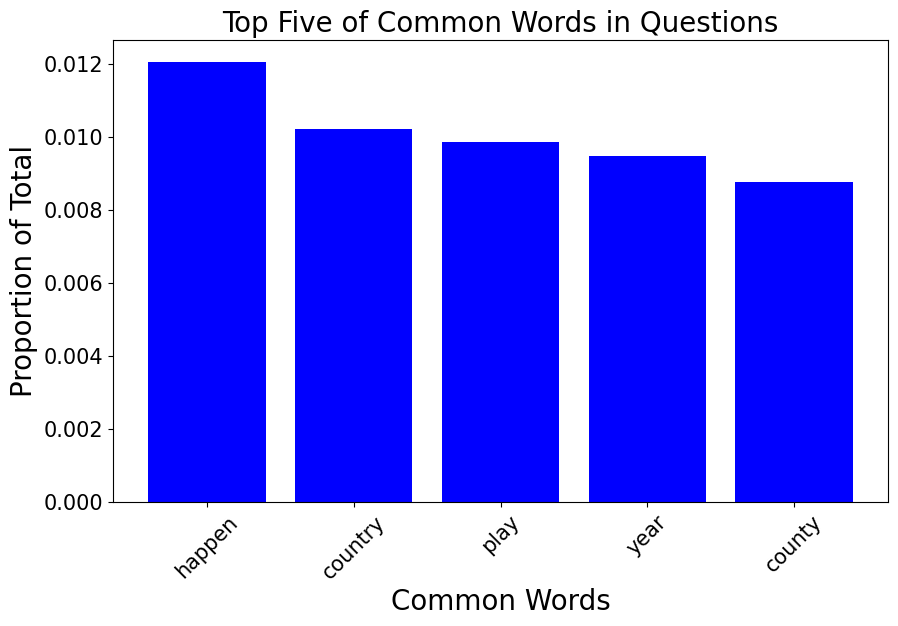

In [101]:
# 5 top common words in questions
plot_top_five_common_words(df_question_common_words_phrases['common_word1'],title='Top Five of Common Words in Questions',xlabel='Common Words')

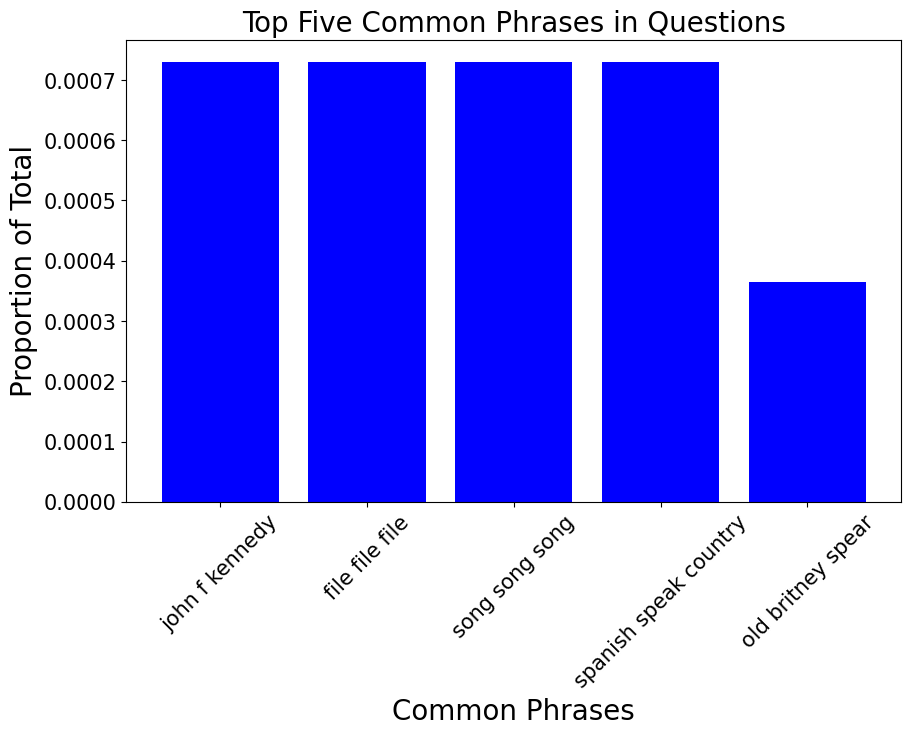

In [102]:
# 5 top common phrases in questions
plot_top_five_common_words(df_question_common_words_phrases['common_phrases'], title='Top Five Common Phrases in Questions',xlabel='Common Phrases')

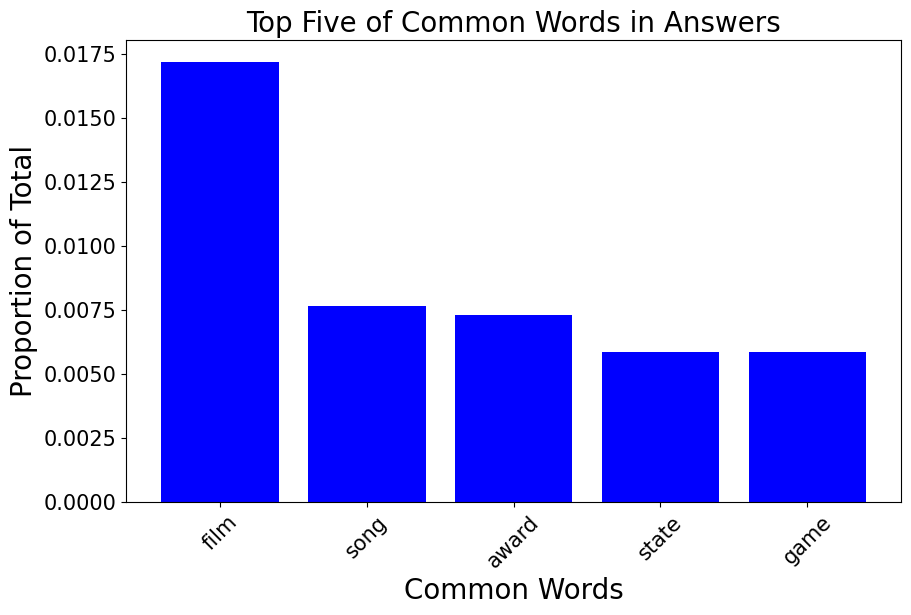

In [103]:
# 5 common words in Answers
plot_top_five_common_words(df_sentences_common_words_phrases['common_word1'], title='Top Five of Common Words in Answers',xlabel='Common Words')

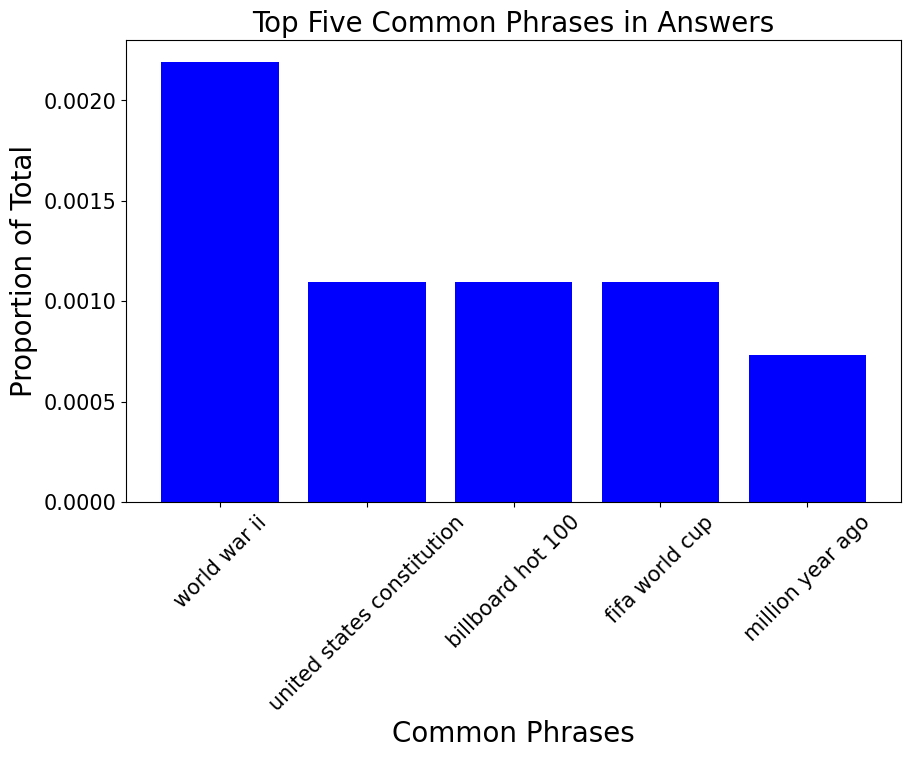

In [104]:
# 5 top common phrases in sentences
plot_top_five_common_words(df_sentences_common_words_phrases['common_phrases'], title='Top Five Common Phrases in Answers',xlabel='Common Phrases')

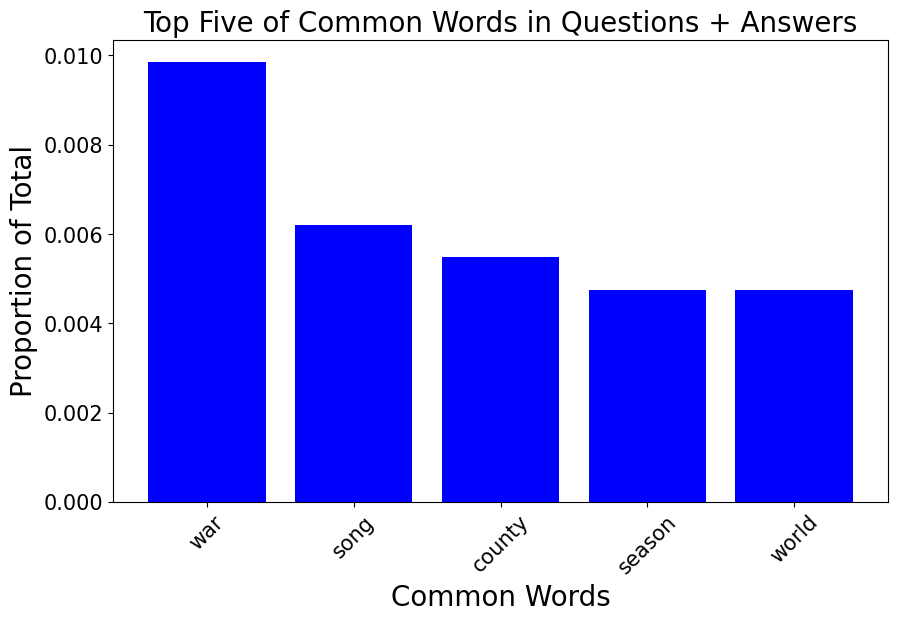

In [105]:
# 5 top common words in Q+A
plot_top_five_common_words(df_agg_question_answer_common_words_phrases['common_word1'], title='Top Five of Common Words in Questions + Answers',xlabel='Common Words')

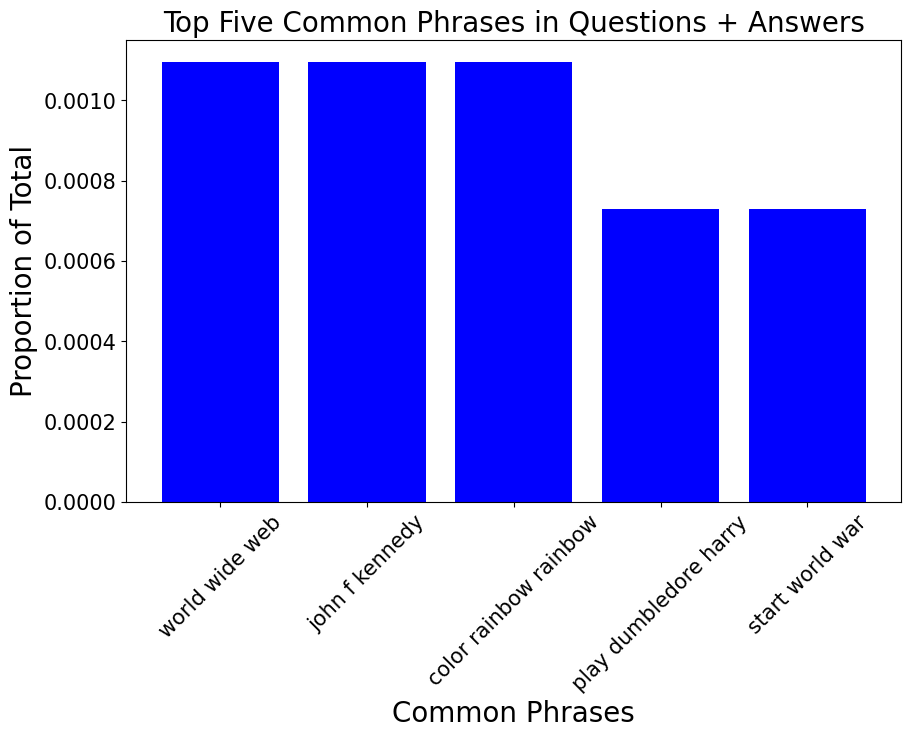

In [106]:
# 5 top common words in Q+A
plot_top_five_common_words(df_agg_question_answer_common_words_phrases['common_phrases'], title='Top Five Common Phrases in Questions + Answers',xlabel='Common Phrases')

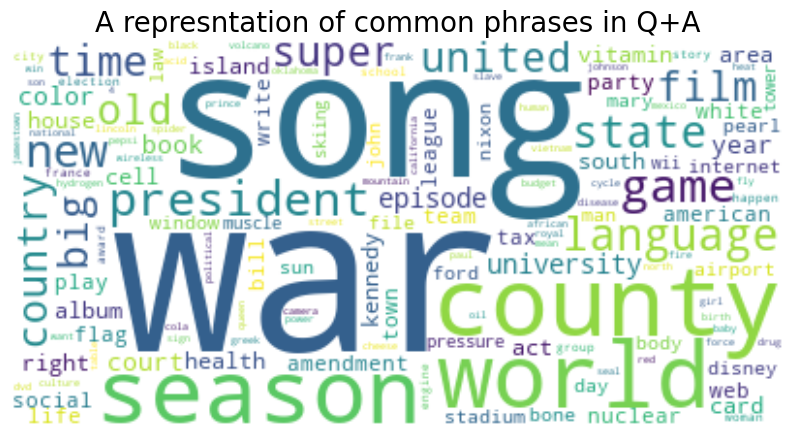

In [107]:
# Word cloud of the common  in Q+A
dic_phrases_count = df_agg_question_answer_common_words_phrases['common_word1'].value_counts().to_dict()

# Create a word cloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(dic_phrases_count)

# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('A represntation of common phrases in Q+A', fontsize=20)
plt.show()

Token count

In [108]:
# Find the maximum token count to determine padding length
# ONLY done on test set to avoid data leakage
def count_tokens(text):
    # Tokenise the text and return the number of tokens
    doc = analysis_nlp(text)
    return len(doc)

# Apply the token counting to each sentence in your DataFrame
df_spacy_analysis['Sentence_token_count'] = df_spacy_analysis['Sentence'].apply(count_tokens)
df_spacy_analysis['Question_token_count'] = df_spacy_analysis['Question'].apply(count_tokens)

# Training data
df_train = pd.read_csv('WikiQACorpus/train.csv')


max_length_sentence = df_spacy_analysis['Sentence_token_count'].max()
max_length_question = df_spacy_analysis['Question_token_count'].max()
max_length = max(max_length_sentence, max_length_question)
max_length

591

 Preprocessing pipeline

- Spacy to tokeniser, lemmatizer, stop word removal, punctuation removal, number removal Vs Spacy to tokeniser, lemmatizer, stop word removal, remove punctuation, lower
- Spacy to remove common words that do not impart value
- Regex to remove miscellanous characters e.g. letters with accents
- Dropping empty text cells
- Reverse the strings to increase short term dependencies
- Tokenisation
- Padding

In [109]:
# Enable GPU for spacy
print(spacy.require_gpu())
pipe_nlp = spacy.load('en_core_web_lg')

True


In [110]:
# Spacy pipline

# With numbers preserved as there are number that are dates that could be relevant to the task.

def num_spacy_pipeline(text):
    doc = pipe_nlp(text.lower())
    # Tokeniser, lemmatizer, stop word removal, punctuation removal, keep numbers, lower case
    return  " ".join([token.lemma_ for token in doc if (token.is_alpha or token.like_num) and not token.is_stop and not token.is_punct])

# Numbers not preserved

def no_num_spacy_pipeline(text):
    doc = pipe_nlp(text.lower())
    # Tokeniser, lemmatizer, stop word removal, punctuation removal, lower case, remove numbers
    return  " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not token.is_punct])
    

In [111]:
# Spacy to remove common words that do not impart value

'''Type words to be removed from the text

create a variable for each word and a list of the words to be removed
e.g: word_one = [[{"LOWER": "article"}], [{"LOWER": "articles"}]]

then creater a matcher and add the words to be removed
e.g: matcher.add("article", word_one)

finally, remove the words from the text using the 'remove_words' function'''
# Words to be removed, note forms of words will not be removed:
question_word = [{"LOWER": "happen"}]
sentence_word = [{"LOWER": "film"}]

# Creating a matcher for question and sentence
matcher_question = spacy.matcher.Matcher(pipe_nlp.vocab)
matcher_answer = spacy.matcher.Matcher(pipe_nlp.vocab)
# Add the words to matcher for removal:
matcher_question.add("happen", [question_word])
matcher_answer.add("film", [sentence_word])
# Removing the most common words
def remove_words(text,col):
    doc = pipe_nlp(text)
    if col == 'question':
        matches = matcher_question(doc)
    elif col == 'sentence':
        matches = matcher_answer(doc)
        
    for match_id, start, end in matches:
        span = doc[start:end]
        text = text.replace(span.text, "")
        
    return text


In [112]:
# regex to remove miscellanous characters
def regx_clean_text(df,col):
    # letters with accents
    pattern = r'[^\x00-\x7F]+'
    
    df[col] = df[col].apply(lambda x: re.sub(pattern, '', x))
    
    return df


In [113]:
# Dropping empty text cells
def drop_empty_text(df,col):
    df.drop(df[df[col]==''].index, inplace=True)
    
    return df

In [114]:
# Reversing words to improve short term dependency. Advice taken from the paper by
# Sutskever, I., Vinyals, O. and Le, Q.V., 2014. Sequence to sequence learning with neural networks. 
# Advances in neural information processing systems, 27.
def reverse_text(df,col):
    df.loc[:,col] = df[col].apply(lambda x: ' '.join(x.split(' ')[::-1]))
    return df

In [115]:
# Tokenising the text
def tokenise(text):
    doc = pipe_nlp(text)
    return [token.text for token in doc]

With word analysis implementation

In [116]:
# This pipeline is designed to be modular to allow for gradual implementation of analysis findings.

def with_analysis_findings(df, name, apply_spacy_num=True, apply_spacy_no_num=False, remove_common=True, 
                  apply_regex=True, reverse_words=True):
    
    # Spacy pipeline with numbers preserved
    if apply_spacy_num:
        df['Question'] = df['Question'].apply(num_spacy_pipeline)
        df['Sentence'] = df['Sentence'].apply(num_spacy_pipeline)
        
    # Spacy pipeline with numbers removed    
    if apply_spacy_no_num:
        df['Question'] = df['Question'].apply(no_num_spacy_pipeline)
        df['Sentence'] = df['Sentence'].apply(no_num_spacy_pipeline)
        
    # Removing common words
    if remove_common:
        df['Question'] = df['Question'].apply(remove_words, col='question')
        df['Sentence'] = df['Sentence'].apply(remove_words, col='sentence')
        
    # Regex cleaning
    if apply_regex:
        regx_clean_text(df, 'Question')
        regx_clean_text(df, 'Sentence')
    
    # Reversing the words
    if reverse_words:
        df = reverse_text(df, 'Question')
        df = reverse_text(df, 'Sentence')
    
    # Dropping empty text cells
        df = drop_empty_text(df, 'Question')
        df = drop_empty_text(df, 'Sentence')
        
    # Tokenizing the text
        df['Question'] = df['Question'].apply(tokenise)
        df['Sentence'] = df['Sentence'].apply(tokenise)
        
    # Dropping unwanted columns
        col = ['Question', 'Sentence', 'Label']
        df = df[col]
        df.rename(columns={'Question': 'question', 'Sentence': 'answer', 'Label': 'label'}, inplace=True)
        
    # Saving the cleaned DataFrame to a CSV file
    df.to_csv(f'WikiQACorpus/{name}_with_analysis_cleaned.csv', index=False)

    

In [212]:
# Training data: analysis findings applied  
df_train = pd.read_csv('WikiQACorpus/train.csv')
with_analysis_findings(df_train, 'train')

C:\Users\gregb\AppData\Local\Temp\ipykernel_38336\2810005571.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Question': 'question', 'Sentence': 'answer', 'Label': 'label'}, inplace=True)


In [117]:
# Validation data: analysis findings applied  
df_val = pd.read_csv('WikiQACorpus/val.csv')
with_analysis_findings(df_val, 'val')

C:\Users\gregb\AppData\Local\Temp\ipykernel_37480\2247784161.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Question': 'question', 'Sentence': 'answer', 'Label': 'label'}, inplace=True)


In [118]:
# Test data: analysis findings applied
df_test = pd.read_csv('WikiQACorpus/test.csv')
with_analysis_findings(df_test, 'test')

C:\Users\gregb\AppData\Local\Temp\ipykernel_37480\2247784161.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Question': 'question', 'Sentence': 'answer', 'Label': 'label'}, inplace=True)


No analysis preprocessing pipeline

In [119]:
# Creating a function to run the full pipeline. This does not implement analysis findings.
def no_analysis_pipeline(df, name):
    
    # Spacy pipeline with numbers preserved
    df.loc[:,'Question'] = df['Question'].apply(num_spacy_pipeline)
    df.loc[:,'Sentence'] = df['Sentence'].apply(num_spacy_pipeline)
    
    # Dropping empty text cells
    drop_empty_text(df,'Question')
    drop_empty_text(df,'Sentence')
    
    # Tokenising the text
    df.loc[:,'Question'] = df['Question'].apply(tokenise)
    
    # Dropping unwanted columns
    col =[ 'Question', 'Sentence','Label']
    df = df[col]
    df.rename(columns={'Question':'question', 'Sentence':'answer','Label':'label'}, inplace=True)
    df.to_csv(f'WikiQACorpus/{name}cleaned.csv', index=False)




In [216]:
# Training data: no analysis applied
df_train = pd.read_csv('WikiQACorpus/train.csv')
no_analysis_pipeline(df_train, 'train')

C:\Users\gregb\AppData\Local\Temp\ipykernel_38336\3630456616.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Question':'question', 'Sentence':'answer','Label':'label'}, inplace=True)


In [120]:
# Validation data: no analysis applied
df_val = pd.read_csv('WikiQACorpus/val.csv')
no_analysis_pipeline(df_val,"val")

C:\Users\gregb\AppData\Local\Temp\ipykernel_37480\1763786359.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Question':'question', 'Sentence':'answer','Label':'label'}, inplace=True)


In [121]:
# Test data: no analysis applied
df_test = pd.read_csv('WikiQACorpus/test.csv')
no_analysis_pipeline(df_test, "test")

C:\Users\gregb\AppData\Local\Temp\ipykernel_37480\1763786359.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Question':'question', 'Sentence':'answer','Label':'label'}, inplace=True)
